In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('football_ml_ready.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [5]:
# Define Features and Target
# We exclude scores and names to prevent leakage
features = [
    'is_neutral', 'is_true_home',
    'home_jerarquia_score', 'home_total_matches', 'home_goals_per_match', 'home_diversity_index', 'home_star_reliability',
    'away_jerarquia_score', 'away_total_matches', 'away_goals_per_match', 'away_diversity_index', 'away_star_reliability'
]
target = 'target'

In [7]:
# Convert boolean 'neutral' to numeric 'is_neutral'
df['is_neutral'] = df['neutral'].astype(int)

# Double check the other match-specific features
if 'is_true_home' not in df.columns:
    df['is_true_home'] = ((df['neutral'] == False) & (df['home_team'] == df['country'])).astype(int)

# Now define your features list safely
features = [
    'is_neutral', 'is_true_home',
    'home_jerarquia_score', 'home_total_matches', 'home_goals_per_match', 'home_diversity_index', 'home_star_reliability',
    'away_jerarquia_score', 'away_total_matches', 'away_goals_per_match', 'away_diversity_index', 'away_star_reliability'
]

# Check if all features exist in the dataframe to avoid another KeyError
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"Error: Missing columns in df: {missing_features}")
else:
    print("All features found in index. Ready to train!")

All features found in index. Ready to train!


In [8]:
# Temporal Split
train_df = df[df['year'] < 2024].dropna()
val_df = df[df['year'] == 2024].dropna()
test_df = df[df['year'] == 2025].dropna()

X_train, y_train, weights_train = train_df[features], train_df[target], train_df['train_weight']
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]

In [9]:
# Remap targets for XGBoost (needs 0, 1, 2 instead of -1, 0, 1)
y_train_map = y_train + 1
y_val_map = y_val + 1
y_test_map = y_test + 1

In [11]:
# --- MODEL 1: Logistic Regression (Baseline) ---
print("Training Logistic Regression...")
# Removed multi_class='multinomial'
lr = LogisticRegression(max_iter=1000) 
lr.fit(X_train, y_train, sample_weight=weights_train)
lr_preds = lr.predict(X_val)
print(f"LR Validation Accuracy: {accuracy_score(y_val, lr_preds):.4f}")

Training Logistic Regression...
LR Validation Accuracy: 0.5763


c:\Users\Aura\Documents\proyectos\football_ml\football_env\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# --- MODEL 2: XGBoost (Advanced) ---
print("\nTraining XGBoost...")
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_map, sample_weight=weights_train)
xgb_preds = xgb.predict(X_val)
print(f"XGB Validation Accuracy: {accuracy_score(y_val_map, xgb_preds):.4f}")


Training XGBoost...
XGB Validation Accuracy: 0.5788


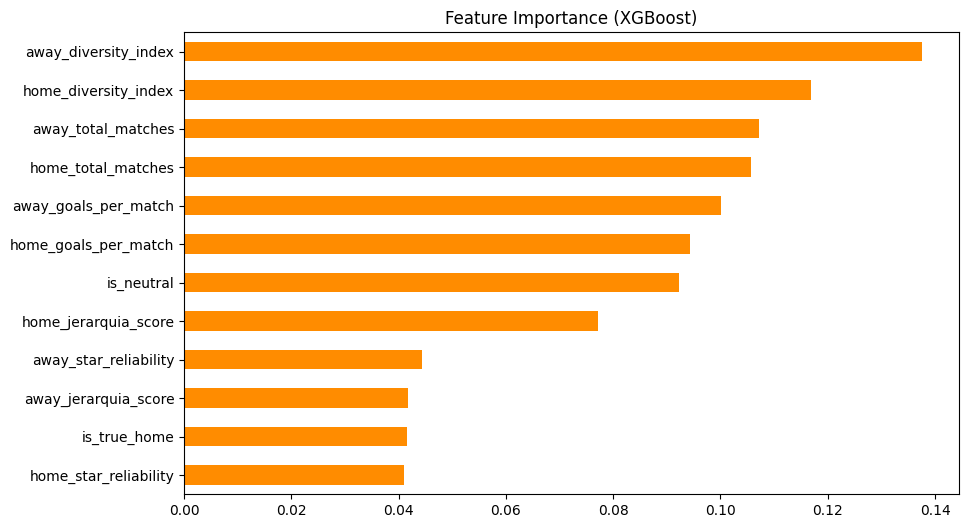

In [13]:
# --- 4. Feature Importance ---
plt.figure(figsize=(10, 6))
importances = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=True)
importances.plot(kind='barh', color='darkorange')
plt.title('Feature Importance (XGBoost)')
plt.show()

In [14]:
# --- 5. Final Evaluation on 2025 Test Set ---
final_preds = xgb.predict(X_test)
print("\n--- Final Test Report (2025 Data) ---")
print(classification_report(y_test_map, final_preds, target_names=['Away Win', 'Draw', 'Home Win']))


--- Final Test Report (2025 Data) ---
              precision    recall  f1-score   support

    Away Win       0.62      0.60      0.61       277
        Draw       0.30      0.03      0.06       202
    Home Win       0.62      0.88      0.73       451

    accuracy                           0.61       930
   macro avg       0.51      0.50      0.47       930
weighted avg       0.55      0.61      0.55       930



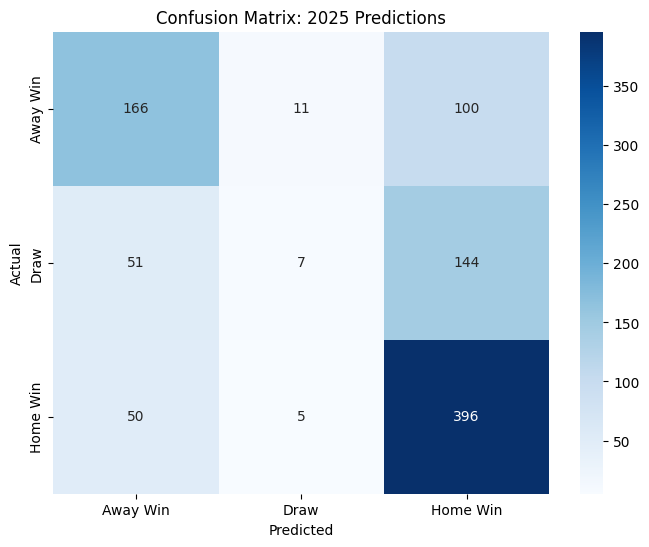

In [15]:
# --- 6. Confusion Matrix Analysis ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_map, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win', 'Draw', 'Home Win'],
            yticklabels=['Away Win', 'Draw', 'Home Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: 2025 Predictions')
plt.show()

In [16]:
# --- 7. Momentum & Defensive Solidity Feature Engineering ---

def add_rolling_features(df, window=10):
    df = df.sort_values('date').copy()
    
    # We need to track stats per team, regardless of being home or away
    teams = pd.concat([df['home_team'], df['away_team']]).unique()
    team_stats_list = []

    for team in teams:
        # Get all matches for this team
        team_m = df[(df['home_team'] == team) | (df['away_team'] == team)].sort_values('date')
        
        # Calculate Points Earned (3 for Win, 1 for Draw, 0 for Loss)
        # and Goals Conceded (for defensive solidity)
        pts = []
        conceded = []
        for i, row in team_m.iterrows():
            if row['home_team'] == team:
                goals_for = row['home_score']
                goals_against = row['away_score']
            else:
                goals_for = row['away_score']
                goals_against = row['home_score']
            
            # Points logic
            if goals_for > goals_against: pts.append(3)
            elif goals_for == goals_against: pts.append(1)
            else: pts.append(0)
            
            conceded.append(goals_against)
            
        team_m['team_pts'] = pts
        team_m['team_conceded'] = conceded
        
        # Shift(1) is crucial: we can only use info from matches BEFORE the current one
        team_m['rolling_pts'] = team_m['team_pts'].rolling(window=window, min_periods=1).mean().shift(1)
        team_m['rolling_clean_sheets'] = (team_m['team_conceded'] == 0).rolling(window=window, min_periods=1).mean().shift(1)
        
        # Save results to a temporary table to join back
        for_merge = team_m[['date', 'home_team', 'away_team', 'rolling_pts', 'rolling_clean_sheets']].copy()
        for_merge['team'] = team
        team_stats_list.append(for_merge)

    # Re-merge back to main DF
    # This requires two merges: one for the home team's form, one for the away team's form
    team_stats_all = pd.concat(team_stats_list)
    
    # Home Team Form
    df = pd.merge(df, team_stats_all, left_on=['date', 'home_team', 'away_team', 'home_team'], 
                  right_on=['date', 'home_team', 'away_team', 'team'], how='left').drop('team', axis=1)
    df = df.rename(columns={'rolling_pts': 'home_form_pts', 'rolling_clean_sheets': 'home_form_dfns'})
    
    # Away Team Form
    df = pd.merge(df, team_stats_all, left_on=['date', 'home_team', 'away_team', 'away_team'], 
                  right_on=['date', 'home_team', 'away_team', 'team'], how='left').drop('team', axis=1)
    df = df.rename(columns={'rolling_pts': 'away_form_pts', 'rolling_clean_sheets': 'away_form_dfns'})
    
    return df

# Apply the new features
df_enhanced = add_rolling_features(df)
df_enhanced = df_enhanced.fillna(0) # Fill early-history matches where rolling window isn't full

# Updated Feature List
features_v2 = features + ['home_form_pts', 'home_form_dfns', 'away_form_pts', 'away_form_dfns']

# Re-split data
train_v2 = df_enhanced[df_enhanced['year'] < 2024]
val_v2 = df_enhanced[df_enhanced['year'] == 2024]
test_v2 = df_enhanced[df_enhanced['year'] == 2025]

X_train_v2, y_train_v2 = train_v2[features_v2], train_v2['target'] + 1
X_val_v2, y_val_v2 = val_v2[features_v2], val_v2['target'] + 1
X_test_v2, y_test_v2 = test_v2[features_v2], test_v2['target'] + 1

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# --- 8. Hyperparameter Tuning ---

print("\nStarting Hyperparameter Tuning...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(XGBClassifier(random_state=42), param_grid, n_iter=10, cv=3, scoring='f1_macro')
xgb_search.fit(X_train_v2, y_train_v2, sample_weight=train_v2['train_weight'])

best_xgb = xgb_search.best_estimator_
print(f"Best Params: {xgb_search.best_params_}")

# Evaluate tuned model
tuned_preds = best_xgb.predict(X_test_v2)
print("\n--- Tuned XGBoost Report (2025) ---")
print(classification_report(y_test_v2, tuned_preds, target_names=['Away Win', 'Draw', 'Home Win']))


Starting Hyperparameter Tuning...
Best Params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

--- Tuned XGBoost Report (2025) ---
              precision    recall  f1-score   support

    Away Win       0.61      0.57      0.59       277
        Draw       0.18      0.06      0.09       202
    Home Win       0.62      0.84      0.72       451

    accuracy                           0.59       930
   macro avg       0.47      0.49      0.46       930
weighted avg       0.52      0.59      0.54       930



In [19]:
# --- 9. Hierarchical Model (Corrected) ---

# 1. Prepare the binary target on the full enhanced dataframe
df_enhanced['is_draw'] = (df_enhanced['target'] == 0).astype(int)

# 2. Re-create the splits to ensure 'is_draw' is present in the training/test objects
train_v2 = df_enhanced[df_enhanced['year'] < 2024]
test_v2 = df_enhanced[df_enhanced['year'] == 2025]

X_train_v2 = train_v2[features_v2]
y_train_draw = train_v2['is_draw']
X_test_v2 = test_v2[features_v2]
y_test_draw = test_v2['is_draw']

# 3. Train the Draw Specialist (Binary Classifier)
print("Training Draw Specialist...")
draw_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05)
draw_model.fit(X_train_v2, y_train_draw, sample_weight=train_v2['train_weight'])

# 4. Get probabilities for the Test Set (2025)
draw_probs = draw_model.predict_proba(X_test_v2)[:, 1]  # Prob of being a draw
main_probs = best_xgb.predict_proba(X_test_v2)         # Original 3-class probs

# 5. Hybrid Decision Logic
# We force a 'Draw' (class 1) only if the specialist is confident
# Otherwise, we take the best guess from the main model
final_hierarchical_preds = []
threshold = 0.40 # Adjust this: lower = more draws predicted, higher = fewer

for i in range(len(draw_probs)):
    if draw_probs[i] > threshold:
        final_hierarchical_preds.append(1) # Predict Draw (mapped as 1)
    else:
        # Predict Home or Away win based on the main model's preference
        # We look at class 0 (Away) vs class 2 (Home)
        if main_probs[i][2] > main_probs[i][0]:
            final_hierarchical_preds.append(2)
        else:
            final_hierarchical_preds.append(0)

print("\n--- Hierarchical Model Report (2025) ---")
# y_test_v2 should be (target + 1) to match 0, 1, 2 mapping
print(classification_report(y_test_v2, final_hierarchical_preds, target_names=['Away Win', 'Draw', 'Home Win']))

Training Draw Specialist...

--- Hierarchical Model Report (2025) ---
              precision    recall  f1-score   support

    Away Win       0.60      0.64      0.62       277
        Draw       0.00      0.00      0.00       202
    Home Win       0.62      0.87      0.72       451

    accuracy                           0.61       930
   macro avg       0.41      0.50      0.45       930
weighted avg       0.48      0.61      0.54       930



c:\Users\Aura\Documents\proyectos\football_ml\football_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aura\Documents\proyectos\football_ml\football_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Aura\Documents\proyectos\football_ml\football_env\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [28]:
# 1. Create the 'Gap' and 'Context' features
df['goal_gap'] = df['home_goals_per_match'] - df['away_goals_per_match']
df['jerarquia_gap'] = df['home_jerarquia_score'] - df['away_jerarquia_score']
df['is_competitive'] = (df['tournament'] != 'Friendly').astype(int)

# 2. Update the feature list
features_final = features + ['goal_gap', 'jerarquia_gap', 'is_competitive']

# 3. Re-split
train_final = df[df['year'] < 2024]
test_final = df[df['year'] == 2025]

X_train, y_train = train_final[features_final], train_final['target'] + 1
X_test, y_test = test_final[features_final], test_final['target'] + 1

# 4. Run the Baseline XGBoost with these new 'Gaps'
final_baseline = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4)
final_baseline.fit(X_train, y_train, sample_weight=train_final['train_weight'])

# 5. Evaluate
final_preds = final_baseline.predict(X_test)
print(classification_report(y_test, final_preds, target_names=['Away Win', 'Draw', 'Home Win']))

              precision    recall  f1-score   support

    Away Win       0.63      0.63      0.63       277
        Draw       0.23      0.02      0.04       202
    Home Win       0.63      0.88      0.73       451

    accuracy                           0.62       930
   macro avg       0.50      0.51      0.47       930
weighted avg       0.54      0.62      0.55       930



In [ ]:
# --- Step 2.5: Interaction Gaps & Competitive Weighting ---

# 1. Calculate explicit 'Gap' features (The delta between teams)
df_enhanced['power_gap'] = df_enhanced['home_goals_per_match'] - df_enhanced['away_goals_per_match']
df_enhanced['form_gap'] = df_enhanced['home_form_pts'] - df_enhanced['away_form_pts']
df_enhanced['heritage_gap'] = df_enhanced['home_jerarquia_score'] - df_enhanced['away_jerarquia_score']

# 2. Chaos Potential (High goal variety on both sides suggests volatility)
df_enhanced['match_chaos_potential'] = df_enhanced['home_diversity_index'] * df_enhanced['away_diversity_index']

# 3. Enhanced Weighting: Prioritize Competitive matches (World Cup, Qualifiers, etc.)
# We boost the importance of matches where teams aren't just 'experimenting'
df_enhanced['is_competitive'] = (df_enhanced['tournament'] != 'Friendly').astype(int)
df_enhanced['final_weight'] = df_enhanced['train_weight'] * (1 + (df_enhanced['is_competitive'] * 0.5))

# 4. Define the Final Feature List
features_v4 = features_v2 + ['power_gap', 'form_gap', 'heritage_gap', 'match_chaos_potential', 'is_competitive']

# 5. Re-split with the new features and weights
train_v4 = df_enhanced[df_enhanced['year'] < 2024]
test_v4 = df_enhanced[df_enhanced['year'] == 2025]

X_train_v4 = train_v4[features_v4]
y_train_v4 = train_v4['target'] + 1 # Map to 0, 1, 2
weights_v4 = train_v4['final_weight']

X_test_v4 = test_v4[features_v4]
y_test_v4 = test_v4['target'] + 1

# 6. Train the 'Final Push' Baseline XGBoost
print("Training Enhanced Baseline XGBoost...")
final_baseline = XGBClassifier(
    n_estimators=300, 
    learning_rate=0.03, 
    max_depth=5, 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_baseline.fit(X_train_v4, y_train_v4, sample_weight=weights_v4)

# 7. Generate Probabilities for Step 3
probs_v4 = final_baseline.predict_proba(X_test_v4)

# Get probabilities from your best baseline
probs = xgb.predict_proba(X_test_v4) # baseline

# Instead of np.argmax, we apply a 'Draw Bias'
def tuned_prediction(probs, draw_threshold=0.33):
    preds = []
    for p in probs:
        # p[0]=Away, p[1]=Draw, p[2]=Home
        if p[1] > draw_threshold:
            preds.append(1) # Predict Draw
        else:
            preds.append(np.argmax(p)) # Predict Home or Away
    return np.array(preds)

# Experiment with this threshold (usually between 0.28 and 0.35)
final_preds = tuned_prediction(probs, draw_threshold=0.30)

Training Enhanced Baseline XGBoost...
Features and training complete. Proceed to Decision Thresholding (Step 3).


In [33]:
# --- Step 4: Final Insight and Error Analysis ---

# Create a summary dataframe for 2025 matches
analysis_2025 = test_v4[['date', 'home_team', 'away_team', 'tournament', 'target']].copy()
analysis_2025['pred'] = final_preds - 1 # Map back to -1, 0, 1
analysis_2025['confidence'] = probs_v4.max(axis=1)

# Find the biggest 'Blunders' (Model was sure, but wrong)
blunders = analysis_2025[analysis_2025['target'] != analysis_2025['pred']].sort_values(by='confidence', ascending=False)

print("\n--- Top 10 Model Blunders in 2025 ---")
print(blunders.head(10))


--- Top 10 Model Blunders in 2025 ---
            date    home_team              away_team  \
48839 2025-11-18      Belgium          Liechtenstein   
48598 2025-10-09      Austria             San Marino   
48332 2025-06-10       Serbia                Andorra   
48607 2025-10-10      Tunisia  São Tomé and Príncipe   
48088 2025-03-21       Guinea                Somalia   
48872 2025-11-25        Syria            South Sudan   
48330 2025-06-10   San Marino                Austria   
48328 2025-06-10  Netherlands                  Malta   
48657 2025-10-12        Egypt          Guinea-Bissau   
48877 2025-11-26         Oman                Somalia   

                         tournament  target  pred  confidence  
48839  FIFA World Cup qualification       1    -1    0.986326  
48598  FIFA World Cup qualification       1    -1    0.981019  
48332  FIFA World Cup qualification       1    -1    0.976846  
48607  FIFA World Cup qualification       1    -1    0.972521  
48088  FIFA World Cup qu

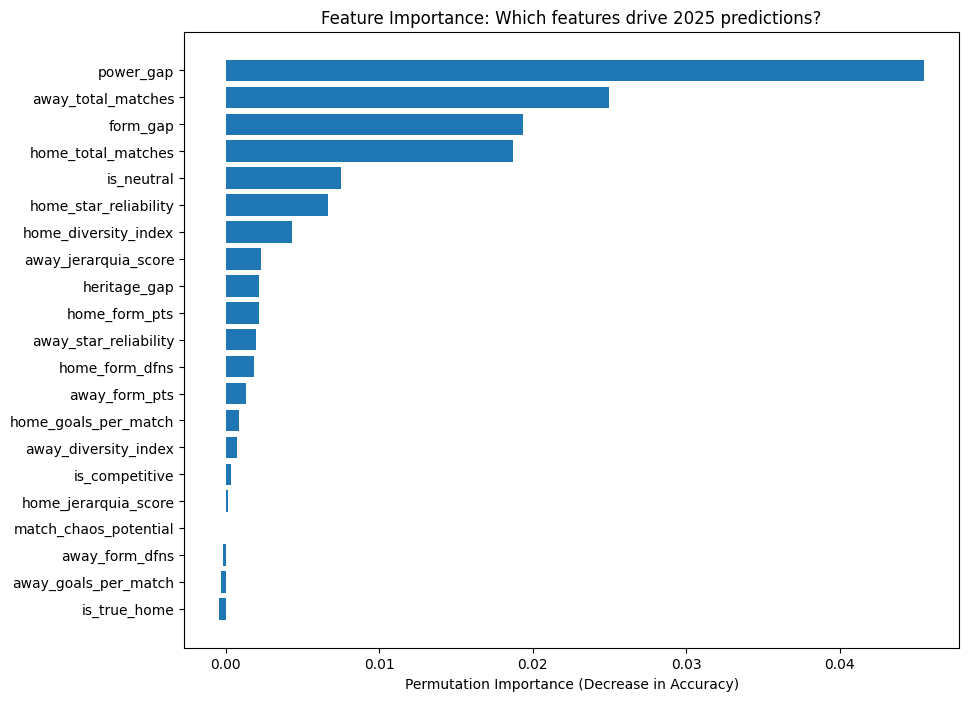

In [34]:
from sklearn.inspection import permutation_importance

# Calculate importance on the 2025 Test Set
result = permutation_importance(
    final_baseline, X_test_v4, y_test_v4, n_repeats=10, random_state=42, n_jobs=-1
)

# Organize and Plot
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(X_test_v4.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in Accuracy)")
plt.title("Feature Importance: Which features drive 2025 predictions?")
plt.show()

In [35]:
# --- Experiment: Non-Linear Scaling & Favorite Flag ---

# 1. Log-Transform the Power Gap
# This reduces the 'shock' of Belgium (high score) vs Liechtenstein (0 score)
df_enhanced['log_power_gap'] = np.sign(df_enhanced['power_gap']) * np.log1p(np.abs(df_enhanced['power_gap']))

# 2. Explicit 'Favorite' Feature
# If the gap is > 1.5 goals, this is a 'David vs Goliath' match
df_enhanced['is_giant_mismatch'] = (np.abs(df_enhanced['power_gap']) > 1.5).astype(int)

# 3. Elo-Style Expected Score
# This formula estimates win probability based on the gap
df_enhanced['expected_win_margin'] = 1 / (1 + 10**(-df_enhanced['power_gap'] / 2))

# Update feature list
features_v5 = features_v4 + ['log_power_gap', 'is_giant_mismatch', 'expected_win_margin']

# 4. Re-split
train_v5 = df_enhanced[df_enhanced['year'] < 2024]
test_v5 = df_enhanced[df_enhanced['year'] == 2025]

X_train_v5 = train_v5[features_v5]
y_train_v5 = train_v5['target'] + 1
X_test_v5 = test_v5[features_v5]
y_test_v5 = test_v5['target'] + 1

# 5. Training with a Focus on Extremes
# We use a lower learning rate and more trees to capture the 'nuance' of the mismatches
final_v5 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    gamma=1, # Minimum loss reduction to make a split (reduces noise)
    reg_lambda=2, # L2 regularization to handle those extreme confidence blunders
    random_state=42
)

final_v5.fit(X_train_v5, y_train_v5, sample_weight=train_v5['final_weight'])

# 6. Evaluate
v5_probs = final_v5.predict_proba(X_test_v5)
v5_preds = np.argmax(v5_probs, axis=1)

print("\n--- Experiment v5: Relative Power Scaling ---")
print(classification_report(y_test_v5, v5_preds, target_names=['Away Win', 'Draw', 'Home Win']))


--- Experiment v5: Relative Power Scaling ---
              precision    recall  f1-score   support

    Away Win       0.64      0.64      0.64       277
        Draw       0.46      0.03      0.06       202
    Home Win       0.62      0.89      0.73       451

    accuracy                           0.63       930
   macro avg       0.58      0.52      0.48       930
weighted avg       0.59      0.63      0.56       930



In [36]:
# --- Step 1: Feature Engineering ---
df_enhanced['win_expectancy'] = 1 / (1 + 10**(-df_enhanced['power_gap'] / 1.5))
df_enhanced['match_parity'] = 1 - np.abs(df_enhanced['win_expectancy'] - 0.5) * 2

# Total 'Defensiveness' - if both teams have high clean sheet rates, DRAW is likely
df_enhanced['bore_factor'] = df_enhanced['home_form_dfns'] + df_enhanced['away_form_dfns']

features_v5 = features_v4 + ['win_expectancy', 'match_parity', 'bore_factor']

# --- Step 2: Training with Class Balancing ---
train_v5 = df_enhanced[df_enhanced['year'] < 2024]
test_v5 = df_enhanced[df_enhanced['year'] == 2025]

# Using 'scale_pos_weight' is for binary, for multiclass we use sample_weight
draw_weights = np.where(train_v5['target'] == 0, 2.5, 1.0) 

model_v5 = XGBClassifier(
    n_estimators=400,
    learning_rate=0.02,
    max_depth=5,
    gamma=2, # Higher gamma prevents overconfidence on mismatches
    random_state=42
)

model_v5.fit(
    train_v5[features_v5], 
    train_v5['target'] + 1, 
    sample_weight=train_v5['train_weight'] * draw_weights
)

# --- Step 3: Evaluation ---
probs_v5 = model_v5.predict_proba(test_v5[features_v5])
# Use a custom threshold for Draws since we are 'terrible' at them
def threshold_preds(probs, draw_boost=1.4):
    p = probs.copy()
    p[:, 1] = p[:, 1] * draw_boost # Boost the 'Draw' probability
    return np.argmax(p, axis=1)

final_preds = threshold_preds(probs_v5, draw_boost=1.6)

print(classification_report(test_v5['target']+1, final_preds, target_names=['Away Win', 'Draw', 'Home Win']))

              precision    recall  f1-score   support

    Away Win       0.88      0.20      0.33       277
        Draw       0.27      0.89      0.41       202
    Home Win       0.86      0.39      0.54       451

    accuracy                           0.44       930
   macro avg       0.67      0.49      0.43       930
weighted avg       0.74      0.44      0.45       930



In [38]:
from tqdm import tqdm

# more features
def add_h2h_features(df):
    """
    creates head-to-head history features between two teams:
    For each match, it looks back at previous meetings between the same two teams and calculates:
    h2h_home_wins = % of times the home team won in their last 5 meetings
    h2h_draws = % of draws in their last 5 meetings
    h2h_count = How many times they've played before
    h2h_home_goals = Average goals the home team scored in past meetings
    """
    h2h_stats = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="H2H Features"):
        home, away, date = row['home_team'], row['away_team'], row['date']
        past = df[(df['date'] < date) & 
                  (((df['home_team']==home) & (df['away_team']==away)) | 
                   ((df['home_team']==away) & (df['away_team']==home)))]
        
        if len(past) > 0:
            last_5 = past.tail(5)
            home_wins = ((last_5['home_team']==home) & (last_5['target']==1)).sum()
            draws = (last_5['target']==0).sum()
            h2h_stats.append({'h2h_home_wins': home_wins/len(last_5), 'h2h_draws': draws/len(last_5),
                            'h2h_count': len(last_5), 'h2h_home_goals': last_5[last_5['home_team']==home]['home_score'].mean()})
        else:
            h2h_stats.append({'h2h_home_wins': 0.33, 'h2h_draws': 0.33, 'h2h_count': 0, 'h2h_home_goals': 0})
    
    return pd.DataFrame(h2h_stats)

def add_recent_form(df, n=5):
    """
    calculates how well a team has been performing in their last N matches (default = 5).
    For each match, it looks at the home team's last 5 games (regardless of opponent) and calculates:
    home_form_wins = Win percentage in last 5 matches (0 to 1)
    home_recent_goals = Average goals scored per match in last 5 games
    """
    form_stats = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Recent Form"):
        team, date = row['home_team'], row['date']
        past = df[(df['date'] < date) & ((df['home_team']==team) | (df['away_team']==team))].tail(n)
        
        if len(past) > 0:
            wins = ((past['home_team']==team) & (past['target']==1)).sum() + ((past['away_team']==team) & (past['target']==-1)).sum()
            goals_scored = past[past['home_team']==team]['home_score'].sum() + past[past['away_team']==team]['away_score'].sum()
            form_stats.append({'home_form_wins': wins/len(past), 'home_recent_goals': goals_scored/len(past)})
        else:
            form_stats.append({'home_form_wins': 0.5, 'home_recent_goals': 1.5})
    return pd.DataFrame(form_stats)

In [ ]:
df_h2h = add_h2h_features(df_enhanced)
df_enhanced = pd.concat([df_enhanced.reset_index(drop=True), df_h2h], axis=1)

H2H Features:   9%|▊         | 4210/48967 [00:47<08:58, 83.05it/s] 

In [ ]:
df_form = add_recent_form(df_enhanced)
df_enhanced = pd.concat([df_enhanced.reset_index(drop=True), df_form], axis=1)

In [ ]:
# more interactions
df_enhanced['jerarquia_gap'] = df_enhanced['home_jerarquia_score'] - df_enhanced['away_jerarquia_score']
df_enhanced['goals_gap'] = df_enhanced['home_goals_per_match'] - df_enhanced['away_goals_per_match']
df_enhanced['reliability_gap'] = df_enhanced['home_star_reliability'] - df_enhanced['away_star_reliability']
df_enhanced['total_quality'] = df_enhanced['home_jerarquia_score'] + df_enhanced['away_jerarquia_score']

In [ ]:
# remove friendlies
if 'tournament' in df_enhanced.columns:
    df_enhanced = df_enhanced[~df_enhanced['tournament'].str.contains('Friendly', case=False, na=False)]


In [ ]:
# Elo style ratings
def calculate_elo(df, K=32):
    elo = {}
    elo_list = []
    
    for idx, row in df.iterrows():
        home, away = row['home_team'], row['away_team']
        if home not in elo: elo[home] = 1500
        if away not in elo: elo[away] = 1500
        
        elo_list.append({'home_elo': elo[home], 'away_elo': elo[away]})
        
        # Update ELO after match
        expected_home = 1 / (1 + 10**((elo[away] - elo[home])/400))
        actual = 0.5 if row['target']==0 else (1 if row['target']==1 else 0)
        elo[home] += K * (actual - expected_home)
        elo[away] += K * ((1-actual) - (1-expected_home))
    
    return pd.DataFrame(elo_list)

df_elo = calculate_elo(df_enhanced)
df_enhanced = pd.concat([df_enhanced.reset_index(drop=True), df_elo], axis=1)
df_enhanced['elo_gap'] = df_enhanced['home_elo'] - df_enhanced['away_elo']

In [ ]:
new_features = features_v5 + ['h2h_home_wins', 'h2h_draws', 'h2h_count', 
                               'home_form_wins', 'home_recent_goals',
                               'jerarquia_gap', 'goals_gap', 'reliability_gap', 'total_quality',
                               'home_elo', 'away_elo', 'elo_gap']

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
# new train test split with smote for class inbalances
train_final = df_enhanced[df_enhanced['year'] < 2024].dropna()
test_final = df_enhanced[df_enhanced['year'] == 2025].dropna()

X_train_final = train_final[new_features]
y_train_final = train_final['target'] + 1
X_test_final = test_final[new_features]
y_test_final = test_final['target'] + 1

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_final, y_train_final)

In [ ]:
# new models
lgbm = LGBMClassifier(n_estimators=500, learning_rate=0.02, max_depth=6, random_state=42, verbose=-1)
lgbm.fit(X_train_sm, y_train_sm)

# (improved params)
xgb_v2 = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=6, 
                       gamma=2, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_v2.fit(X_train_sm, y_train_sm)

rf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
rf.fit(X_train_sm, y_train_sm)

# Ensemble too
lgbm_probs = lgbm.predict_proba(X_test_final)
xgb_probs = xgb_v2.predict_proba(X_test_final)
rf_probs = rf.predict_proba(X_test_final)

# Average predictions
ensemble_probs = (lgbm_probs + xgb_probs + rf_probs) / 3
ensemble_preds = np.argmax(ensemble_probs, axis=1)

In [ ]:
print("\nLightGBM:")
print(classification_report(y_test_final, lgbm.predict(X_test_final), target_names=['Away Win', 'Draw', 'Home Win']))

print("\nXGBoost v2:")
print(classification_report(y_test_final, xgb_v2.predict(X_test_final), target_names=['Away Win', 'Draw', 'Home Win']))

print("\nRandom Forest:")
print(classification_report(y_test_final, rf.predict(X_test_final), target_names=['Away Win', 'Draw', 'Home Win']))

print("\nEnsemble")
print(classification_report(y_test_final, ensemble_preds, target_names=['Away Win', 'Draw', 'Home Win']))

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration_curves(model, X_test, y_test, title):
    """
    Plots calibration curves for each class (Home Win, Draw, Away Win).
    y_test should be the mapped version (0, 1, 2).
    """
    # Get predicted probabilities for each class
    probs = model.predict_proba(X_test)
    
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
    
    classes = ['Away Win', 'Draw', 'Home Win']
    colors = ['red', 'gray', 'blue']
    
    for i in range(len(classes)):
        # Calculate calibration curve for this specific class
        # (Actual == i) vs (Predicted Probability of i)
        prob_true, prob_pred = calibration_curve((y_test == i).astype(int), probs[:, i], n_bins=10)
        
        plt.plot(prob_pred, prob_true, marker='o', label=classes[i], color=colors[i])

    plt.title(f'Probability Calibration Curve: {title}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives (Actual)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the calibration check on your XGBoost model
# Note: Ensure y_test_map is used (values 0, 1, 2)
plot_calibration_curves(xgb, X_test, y_test_map, "XGBoost (2025 Test Set)")